Case 0:
  Continuous Solution - Value: 1.21632, Penalty: 1.00000, Score: 1.21632
  Exact Solution - Value: 1.21632, Penalty: 1.00000, Score: 1.21632
  Qaoa Solution - Value: 1.21632, Penalty: 1.00000, Score: 1.21632

Case 1:
  Continuous Solution - Value: 25.05053, Penalty: 1.00000, Score: 25.05053
  Exact Solution - Value: 25.05053, Penalty: 1.00000, Score: 25.05053
  Qaoa Solution - Value: 25.05053, Penalty: 1.00000, Score: 25.05053

Case 2:
  Continuous Solution - Value: 3.97952, Penalty: 1.00420, Score: 3.96286
  Exact Solution - Value: 3.97952, Penalty: 1.00420, Score: 3.96286
  Qaoa Solution - Value: 1.10556, Penalty: 1.15222, Score: 0.95950

Case 3:
  Continuous Solution - Value: 4.59398, Penalty: 1.00000, Score: 4.59398
  Exact Solution - Value: 4.59398, Penalty: 1.00000, Score: 4.59398
  Qaoa Solution - Value: 4.59398, Penalty: 1.00000, Score: 4.59398

Case 4:
  Continuous Solution - Value: 2.14465, Penalty: 1.01821, Score: 2.10628
  Exact Solution - Value: 2.14465, Penalty: 1

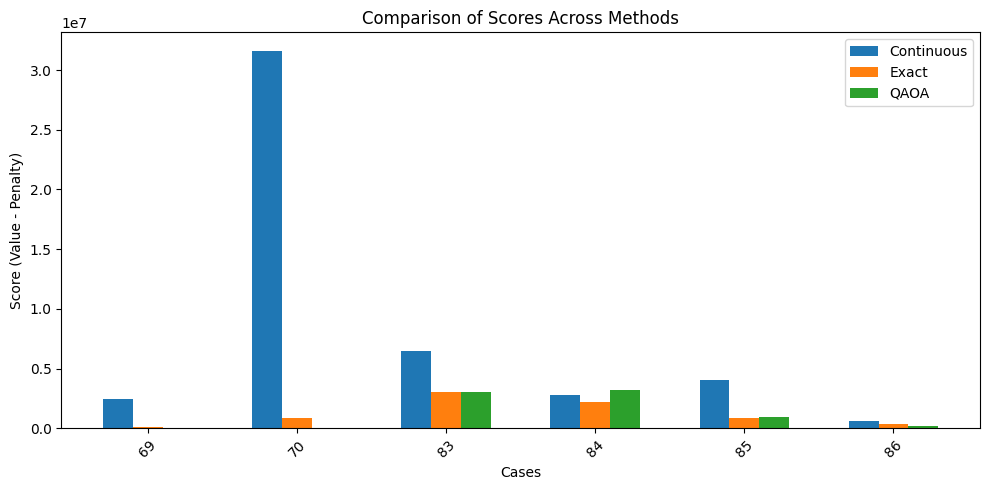

In [6]:
import json
import numpy as np
import matplotlib.pyplot as plt

def load_json(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)
    

def compare_solutions(data):
    results = {}
    
    for case_id, case_data in data.items():
        cont_sol = case_data.get("continuous_variables_solution", {})
        exact_sol = case_data.get("exact_solution", {})
        qaoa_sol = case_data.get("qaoa_solution", {})
        budget = case_data["hyperparams"]["budget"]
        penalizer = 1
        
        cont_value = cont_sol.get("value", 0)
        cont_penalty = 1 + penalizer*cont_sol.get("left_overs", 0)/budget
        
        exact_value = exact_sol.get("objective_values", [])[0]
        exact_budgets = exact_sol.get("result_with_budget", [])[0]
        exact_penalty = 1 + penalizer*abs(exact_budgets["difference"])/budget
        
        qaoa_value = qaoa_sol.get("objective_values", [])[-1]
        qaoa_budgets = qaoa_sol.get("result_with_budget", [])[-1]
        qaoa_penalty = 1 + penalizer*abs(qaoa_budgets["difference"])/budget
        
        results[case_id] = {
            "continuous": {"value": cont_value, "penalty": cont_penalty, "score": cont_value/cont_penalty},
            "exact": {"value": exact_value, "penalty": exact_penalty, "score": exact_value/exact_penalty},
            "qaoa": {"value": qaoa_value, "penalty": qaoa_penalty, "score": qaoa_value/qaoa_penalty}
        }
    
    return results

def plot_scores(results):
    cases = list(results.keys())
    continuous_scores = [results[case]["continuous"]["score"] for case in cases]
    exact_scores = [results[case]["exact"]["score"] for case in cases]
    qaoa_scores = [results[case]["qaoa"]["score"] for case in cases]
    
    x = np.arange(len(cases))
    width = 0.2
    
    plt.figure(figsize=(10, 5))
    plt.bar(x - width, continuous_scores, width, label="Continuous")
    plt.bar(x, exact_scores, width, label="Exact")
    plt.bar(x + width, qaoa_scores, width, label="QAOA")
    
    plt.xlabel("Cases")
    plt.ylabel("Score (Value - Penalty)")
    plt.title("Comparison of Scores Across Methods")
    plt.xticks(ticks=x, labels=cases, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

def main():
    file_path = "portfolio_optimization_results.json"  # Update with actual path
    data = load_json(file_path)
    results = compare_solutions(data)
    
    for case, comparison in results.items():
        print(f"Case {case}:")
        for method, values in comparison.items():
            print(f"  {method.capitalize()} Solution - Value: {values['value']:.5f}, Penalty: {values['penalty']:.5f}, Score: {values['score']:.5f}")
        print()
    
    subset_of_results = {}
    for key in list(results.keys()):
        assets_to_qubits = data[key]["hyperparams"]["assets_to_qubits"]
        n_qubits = sum([len(v) for v in assets_to_qubits.values()])
        if n_qubits == 10:
            subset_of_results[key] = results[key]
    
    plot_scores(subset_of_results)

main()

In [4]:
file_path = "experiments_data.json"
data = load_json(file_path)["data"]
print(json.dumps(data[9], indent=4))


{
    "max_qubits": 2,
    "budget": 177.0,
    "stock_metadata": {
        "WBA": {
            "max_int": 1,
            "qubits": 1,
            "random_int": 0,
            "price": 9.329999923706055
        },
        "BA": {
            "max_int": 1,
            "qubits": 1,
            "random_int": 1,
            "price": 177.0
        }
    },
    "stocks": [
        "WBA",
        "BA"
    ],
    "start": "2015-01-01",
    "end": "2025-01-01",
    "n_stocks": 2
}


In [5]:
file_path = "portfolio_optimization_results.json"  # Update with actual path
data = load_json(file_path)
print(json.dumps(data["9"], indent=4))

{
    "hyperparams": {
        "stocks": [
            "BA",
            "WBA"
        ],
        "start": "2015-01-01",
        "end": "2025-01-01",
        "risk_aversion": 3,
        "max_qubits": 15,
        "budget": 177.0,
        "log_encoding": true,
        "layers": 5,
        "prices_now": {
            "BA": 177.0,
            "WBA": 9.329999923706055
        },
        "assets_to_qubits": {
            "BA": [
                0
            ],
            "WBA": [
                1,
                2,
                3,
                4
            ]
        }
    },
    "continuous_variables_solution": {
        "weights": {
            "BA": 0.48505483696635765,
            "WBA": 0.5149451630336424
        },
        "allocation": {
            "WBA": 14,
            "BA": 0
        },
        "value": 57205.77564501762,
        "left_overs": 46.380001049413124
    },
    "exact_solution": {
        "smallest_eigenvalues": [
            -0.39568965389120436
        ],
 